# Введение в обработку естественного языка

## Урок 8. Рекуррентные нейронные сети RNN LSTM GRU

**Материалы:**
У вас лекционный ноутбук в архиве он с картинками и презентация тоже есть в архиве    

**Задание:**
На вебинаре мы говорили, что долгое время CNN и RNN архитектуры были конурируещими. Выяснить, какая архитектура больше подходит для задачи сантимент анализа на данных с вебинара

1. Построить свёрточные архитектуры 
2. Построить различные архитектуры с RNN
3. Построить совместные архитектуры CNN -> RNN  и (RNN -> CNN)
4. Сделать выводы, что получилось лучше


In [1]:
import numpy as np
import pandas as pd
import keras
import re
import matplotlib.pyplot as plt

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from tensorflow.keras.metrics import categorical_crossentropy
from keras.callbacks import EarlyStopping 
from tensorflow.keras import layers

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_val = pd.read_csv("data/val.csv")

In [3]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [4]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [5]:
df_train.loc[0:2]

,id,text,class
0,0,alisachachkaич уезжаааааааать ❤ тожена хотеть ...,0
1,1,rt galyginvadim ребята девчата кино любовь зав...,1
2,2,rt artemklyushin ктоненавидеть пробка ретвит rt,0


In [6]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

In [7]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)

In [8]:
word_count, training_length

(258108, 27)

In [9]:
y_train = df_train['class'].values
y_val = df_val['class'].values

In [10]:
result = {'name': list(), 'loss': list(), 'accuracy': list()}

# Общие параметры

In [11]:
batch_size = 512
epochs=10
validation_split = 0.1
verbose=1
early_stopping=EarlyStopping(monitor='val_loss')

# SimpleRNN

In [12]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(SimpleRNN(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 49s 148ms/step - loss: 0.5586 - accuracy: 0.6989 - val_loss: 0.4988 - val_accuracy: 0.7514
Epoch 2/10
319/319 [==============================] - 47s 148ms/step - loss: 0.2948 - accuracy: 0.8794 - val_loss: 0.5579 - val_accuracy: 0.7436


In [14]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 0s 11ms/step - loss: 0.5861 - accuracy: 0.7359


Test score: 0.5861487984657288
Test accuracy: 0.735925555229187


In [15]:
result['name'].append('SimpleRNN')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

# LSTM

Какие проблемы у рекурентных сетей?

- затухают градиенты
- медленно, нужно всегда дойти до конца

Как решить? -> LSTM


<img src="images/lstm.png">


https://colah.github.io/posts/2015-08-Understanding-LSTMs/


Давайте, кратко посмотрим как это работает:


<img src="images/LSTMMaths.png">

In [16]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(LSTM(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 73s 221ms/step - loss: 0.5545 - accuracy: 0.7071 - val_loss: 0.4965 - val_accuracy: 0.7520
Epoch 2/10
319/319 [==============================] - 69s 215ms/step - loss: 0.3273 - accuracy: 0.8633 - val_loss: 0.5414 - val_accuracy: 0.7479


In [17]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 20ms/step - loss: 0.5873 - accuracy: 0.7365


Test score: 0.5873300433158875
Test accuracy: 0.7364987134933472


In [18]:
result['name'].append('LSTM')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

# GRU

Какие проблемы:

- вычислительно сложно -> медленнее
- на очень длинных последовательностях все равно затухает градиент


Зачем платить больше - уберем некоторые врата (точнее совместим) -> ускоримся, уменьшим число параметров -> GRU


<img src="images/gru.png">


GRU Math


<img src="images/GRUMath.png">


In [19]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(GRU(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 68s 207ms/step - loss: 0.5542 - accuracy: 0.7058 - val_loss: 0.4921 - val_accuracy: 0.7510
Epoch 2/10
319/319 [==============================] - 65s 204ms/step - loss: 0.3210 - accuracy: 0.8675 - val_loss: 0.5341 - val_accuracy: 0.7474


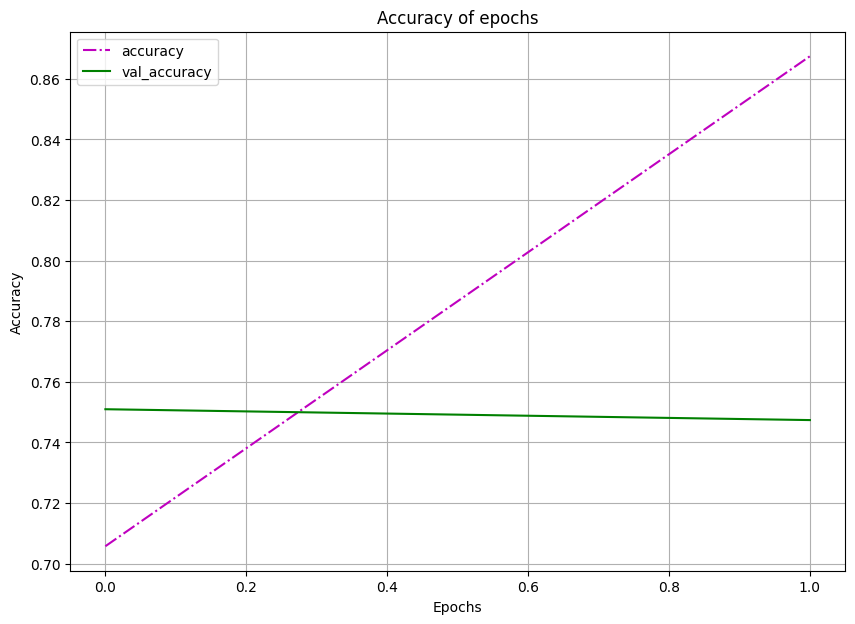

In [20]:
plt.figure(figsize=(10,7))
plt.plot(history.history['accuracy'], '-.', label = f'accuracy', color='m')
plt.plot(history.history['val_accuracy'], '-', label = f'val_accuracy', color='g')
        
plt.legend()
plt.grid('On')
plt.title('Accuracy of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [21]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 16ms/step - loss: 0.5876 - accuracy: 0.7394


Test score: 0.5875657796859741
Test accuracy: 0.7394083738327026


In [22]:
result['name'].append('GRU')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

# CNN

In [23]:
model = Sequential()
model.add(Embedding(input_dim=word_count, 
                    input_length=training_length, 
                    output_dim=30))

model.add(Conv1D(256, 3, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])


Epoch 1/10
319/319 [==============================] - 53s 164ms/step - loss: 0.5490 - accuracy: 0.5076 - val_loss: 0.4858 - val_accuracy: 0.5049
Epoch 2/10
319/319 [==============================] - 53s 165ms/step - loss: 0.2994 - accuracy: 0.5076 - val_loss: 0.5438 - val_accuracy: 0.5049


In [25]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 12ms/step - loss: 0.6058 - accuracy: 0.5047


Test score: 0.605818510055542
Test accuracy: 0.5047392249107361


In [26]:
result['name'].append('CNN')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

# Add Dropout

In [27]:
model_5 = Sequential([
    layers.Embedding(input_dim=word_count, 
                     input_length=training_length, output_dim=30),
    layers.Dropout(0.2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPool1D(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [28]:
model_5.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [29]:
history_5 = model_5.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 24s 73ms/step - loss: 0.6135 - accuracy: 0.6462 - val_loss: 0.5423 - val_accuracy: 0.7187
Epoch 2/10
319/319 [==============================] - 24s 75ms/step - loss: 0.5020 - accuracy: 0.7539 - val_loss: 0.5043 - val_accuracy: 0.7444
Epoch 3/10
319/319 [==============================] - 24s 77ms/step - loss: 0.4351 - accuracy: 0.8034 - val_loss: 0.5002 - val_accuracy: 0.7476
Epoch 4/10
319/319 [==============================] - 23s 74ms/step - loss: 0.3691 - accuracy: 0.8447 - val_loss: 0.5258 - val_accuracy: 0.7500


In [30]:
score = model_5.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

result['name'].append('Add Dropout')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

45/45 [==============================] - 0s 7ms/step - loss: 0.5606 - accuracy: 0.7405


Test score: 0.5606273412704468
Test accuracy: 0.7405105233192444


# CNN + RNN

In [31]:
model = Sequential([
    layers.Embedding(input_dim=word_count, 
                     input_length=training_length, output_dim=30),
    layers.Dropout(0.2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPool1D(),

    layers.RepeatVector(1),
    layers.LSTM(64, recurrent_dropout=0.2),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='RMSprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [32]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 27s 77ms/step - loss: 0.6579 - accuracy: 0.5888 - val_loss: 0.5799 - val_accuracy: 0.6837
Epoch 2/10
319/319 [==============================] - 26s 81ms/step - loss: 0.5428 - accuracy: 0.7213 - val_loss: 0.5172 - val_accuracy: 0.7375
Epoch 3/10
319/319 [==============================] - 25s 79ms/step - loss: 0.4611 - accuracy: 0.7870 - val_loss: 0.5003 - val_accuracy: 0.7500
Epoch 4/10
319/319 [==============================] - 25s 78ms/step - loss: 0.3942 - accuracy: 0.8312 - val_loss: 0.5091 - val_accuracy: 0.7522


In [33]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 0s 9ms/step - loss: 0.5799 - accuracy: 0.7292


Test score: 0.5798522233963013
Test accuracy: 0.7292245030403137


In [34]:
result['name'].append('CNN + RNN')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

# GRU + CNN

In [35]:
model = Sequential([
    layers.Embedding(input_dim=word_count, 
                     input_length=training_length, output_dim=30),
    layers.Dropout(0.2),
    layers.Conv1D(128, 5, activation='relu'),
    
    layers.GRU(64, recurrent_dropout=0.2),
    layers.RepeatVector(1),
    layers.GlobalMaxPool1D(),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [36]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 83s 253ms/step - loss: 0.5531 - accuracy: 0.7041 - val_loss: 0.4943 - val_accuracy: 0.7508
Epoch 2/10
319/319 [==============================] - 82s 256ms/step - loss: 0.3189 - accuracy: 0.8649 - val_loss: 0.5266 - val_accuracy: 0.7486


In [37]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 27ms/step - loss: 0.5656 - accuracy: 0.7443


Test score: 0.5656017065048218
Test accuracy: 0.7442578077316284


In [38]:
result['name'].append('GRU + CNN optimizer=adam')
result['loss'].append(score[0])
result['accuracy'].append(score[1])

# Result

In [39]:
df_result = pd.DataFrame(result)
df_result

,name,loss,accuracy
0,SimpleRNN,0.586149,0.735926
1,LSTM,0.587330,0.736499
2,GRU,0.587566,0.739408
3,CNN,0.605819,0.504739
4,Add Dropout,0.560627,0.740511
5,CNN + RNN,0.579852,0.729225
6,GRU + CNN optimizer=adam,0.565602,0.744258


#Ответ:
Лучший рез-т показала SimpleRNN - 0.741084.

3 подхода:

<img src="images/RNNCompar.png">


Как регуляризовать?
- дропаут
- рекурентный дропаут


<img src="images/Dropouts.png">